# Dino 2D dataset

In [1]:
import json
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

# internal imports
import sys
sys.path.append('..')
from datasets.data_generator import *
from datasets.flow_synthetic_2Ddata import sample_2d_synthetic
from network_arch.nets import *
from diffusion_models.diffusionmodel import * # import dm classes
from diffusion_models.seq_samplers import * # import samplers

/home/ywu380/miniconda3/envs/cdl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Visualization

### Original Dino on low-dim manifod
This is the original data, which is strongly peaked on a low-dimensional manifod.

(-3.5, 3.5, -3.5, 3.5)

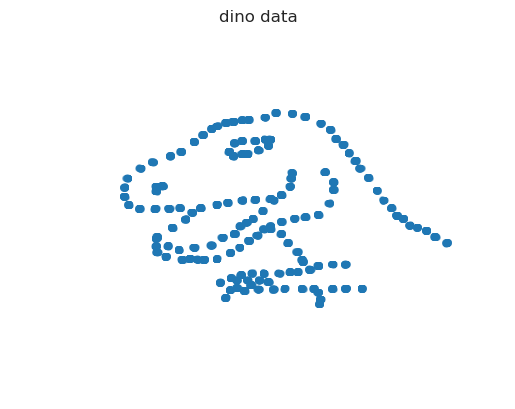

In [2]:
path_2d="../datasets/assets/DatasaurusDozen.tsv"
_, _, x_shape, dataset = dino_dataset(path_2d=path_2d)
x0 = dataset.tensors[0]

# plot the samples, they shape as a dino
plt.subplot(1,1,1)
plt.scatter(x0[:,0], x0[:,1], alpha=0.5, s=15)
plt.title("dino data")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

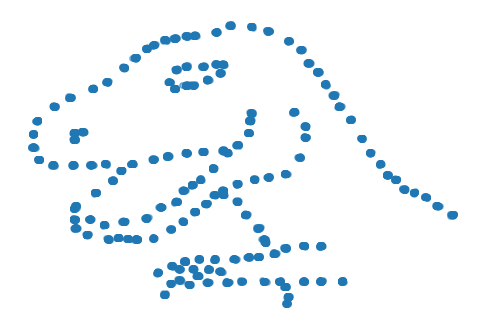

In [3]:
path_2d="../datasets/assets/DatasaurusDozen.tsv"
_, _, x_shape, dataset = dino_dataset(path_2d=path_2d)
x0 = dataset.tensors[0]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x0[:,0], x0[:,1], alpha=0.5, s=15)
plt.axis("off")
plt.show()
fig.savefig(f'./dino_gt.pdf')

### Flow-synthetic Dino
This is the flow-synthetic data, which is used to train our diffusion models

tensor([[ 0.1013, -1.0801],
        [-0.4930,  1.7627],
        [-0.3757, -0.3635],
        ...,
        [ 0.0424, -1.3218],
        [ 0.1845,  0.4068],
        [-0.3201, -1.3795]])
dino.min = -2.091953992843628, dino.max = 2.7930424213409424


(-3.5, 3.5, -3.5, 3.5)

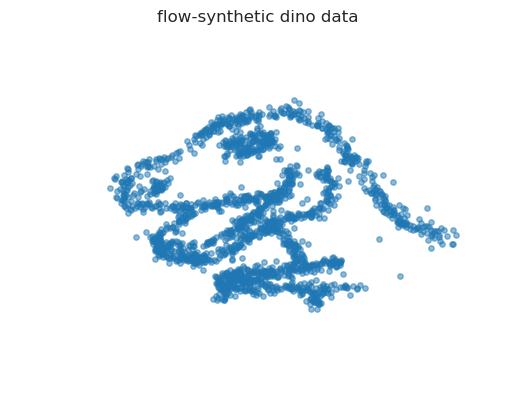

In [4]:
train_ds, val_ds, x_shape = sample_2d_synthetic(dataset="dino", num_samples=2000)

# plot the flow-synthetic samples
train_tensor = train_ds.tensors[0]
print(train_tensor)
print(f'dino.min = {train_tensor.min()}, dino.max = {train_tensor.max()}')
plt.subplot(1,1,1)
plt.scatter(train_tensor[:,0], train_tensor[:,1], alpha=0.5, s=15)
plt.title("flow-synthetic dino data")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

### Parallel sampled Dino, sampled from pretrained diffusion model

#### MMD function test
First test if mmd() function works correctly

In [5]:
BW = torch.tensor(3e-02)

##### Greg's MMD

In [6]:
def mmd(true_samples, x, bw):
    """x is the generated samples, evaluate mmd between x and true samples"""
    # bw = median_heuristic(true_samples)
    # bw = torch.tensor(0.001)
    kyy = kernel(true_samples, true_samples, bw)
    kxx = kernel(x, x, bw)
    kxy = kernel(x, true_samples, bw)
    mmd_mean = mmd_ci_kernel(kxx, kxy, kyy)
    return mmd_mean

In [7]:
bw = torch.linspace(0.001, 3, steps=100)
mmd_data2data = [mmd(train_tensor, train_tensor, bw=bw_i) for bw_i in bw]
print(mmd_data2data)
mmd_data2gauss = [mmd(train_tensor, torch.randn_like(train_tensor), bw=bw_i) for bw_i in bw]
print(mmd_data2gauss)

[tensor(-0.0126), tensor(-0.0022), tensor(-0.0015), tensor(-0.0012), tensor(-0.0011), tensor(-0.0009), tensor(-0.0008), tensor(-0.0008), tensor(-0.0007), tensor(-0.0007), tensor(-0.0006), tensor(-0.0006), tensor(-0.0006), tensor(-0.0005), tensor(-0.0005), tensor(-0.0005), tensor(-0.0005), tensor(-0.0004), tensor(-0.0004), tensor(-0.0004), tensor(-0.0004), tensor(-0.0004), tensor(-0.0004), tensor(-0.0004), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0003), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.0002), tensor(-0.000

In [8]:
mmd_data2data = torch.stack(mmd_data2data)
mmd_data2gauss = torch.stack(mmd_data2gauss)
print(mmd_data2data)
print(mmd_data2gauss)

tensor([-1.2598e-02, -2.2002e-03, -1.5420e-03, -1.2431e-03, -1.0624e-03,
        -9.3765e-04, -8.4473e-04, -7.7190e-04, -7.1276e-04, -6.6344e-04,
        -6.2145e-04, -5.8514e-04, -5.5331e-04, -5.2509e-04, -4.9985e-04,
        -4.7711e-04, -4.5646e-04, -4.3762e-04, -4.2031e-04, -4.0437e-04,
        -3.8962e-04, -3.7591e-04, -3.6315e-04, -3.5120e-04, -3.4003e-04,
        -3.2950e-04, -3.1962e-04, -3.1027e-04, -3.0145e-04, -2.9307e-04,
        -2.8516e-04, -2.7761e-04, -2.7043e-04, -2.6358e-04, -2.5708e-04,
        -2.5085e-04, -2.4487e-04, -2.3917e-04, -2.3370e-04, -2.2846e-04,
        -2.2341e-04, -2.1858e-04, -2.1393e-04, -2.0945e-04, -2.0515e-04,
        -2.0098e-04, -1.9697e-04, -1.9311e-04, -1.8935e-04, -1.8575e-04,
        -1.8227e-04, -1.7888e-04, -1.7561e-04, -1.7247e-04, -1.6939e-04,
        -1.6643e-04, -1.6353e-04, -1.6073e-04, -1.5802e-04, -1.5540e-04,
        -1.5283e-04, -1.5034e-04, -1.4792e-04, -1.4555e-04, -1.4327e-04,
        -1.4105e-04, -1.3887e-04, -1.3677e-04, -1.3

Need to plot log-scale to see clearly which bandwidth to pick

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


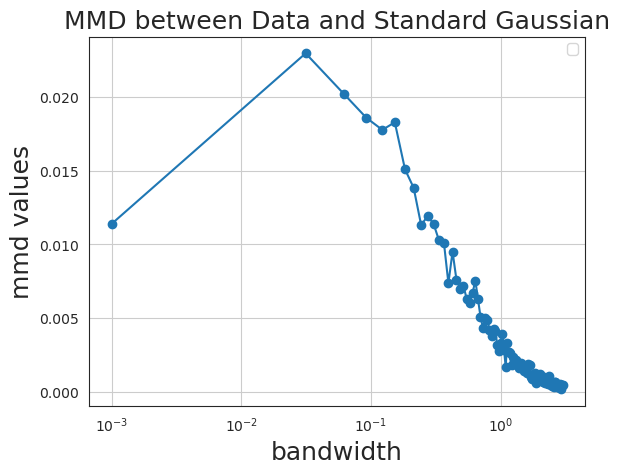

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(bw.numpy(), mmd_data2gauss.numpy(), marker='o', linestyle='-')
ax.set_xlabel('bandwidth', fontsize=18)  # Set font size to 18
ax.set_ylabel('mmd values', fontsize=18)  # Set font size to 18
ax.set_title('MMD between Data and Standard Gaussian', fontsize=18)  # Set font size to 18
ax.grid(True)
ax.set_xscale('log')  # Use set_xscale instead of xscale to set log scale
ax.legend()  # You forgot to specify the labels for the legend
plt.show()
fig.savefig('./mmd_bandwidth_choice.pdf')

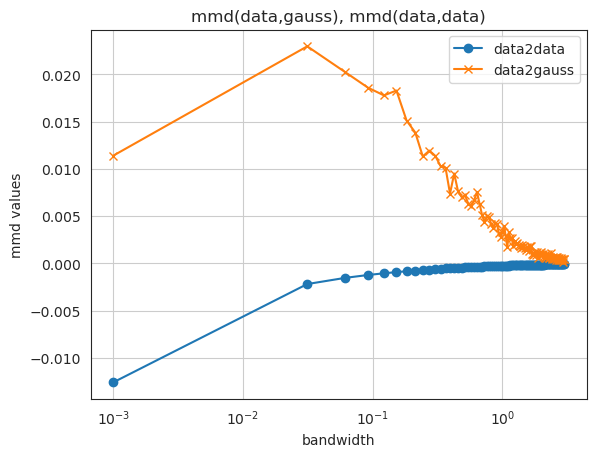

In [10]:
plt.plot(bw.numpy(), mmd_data2data.numpy(), marker='o', linestyle='-', label='data2data')
plt.plot(bw.numpy(), mmd_data2gauss.numpy(), marker='x', linestyle='-', label='data2gauss')
plt.xlabel('bandwidth')
plt.ylabel('mmd values')
plt.title('mmd(data,gauss), mmd(data,data)')
plt.grid(True)
plt.legend()
plt.xscale('log') # set the x-axis to a log scale
plt.show()

In [11]:
print(bw)

tensor([1.0000e-03, 3.1293e-02, 6.1586e-02, 9.1879e-02, 1.2217e-01, 1.5246e-01,
        1.8276e-01, 2.1305e-01, 2.4334e-01, 2.7364e-01, 3.0393e-01, 3.3422e-01,
        3.6452e-01, 3.9481e-01, 4.2510e-01, 4.5539e-01, 4.8569e-01, 5.1598e-01,
        5.4627e-01, 5.7657e-01, 6.0686e-01, 6.3715e-01, 6.6744e-01, 6.9774e-01,
        7.2803e-01, 7.5832e-01, 7.8862e-01, 8.1891e-01, 8.4920e-01, 8.7949e-01,
        9.0979e-01, 9.4008e-01, 9.7037e-01, 1.0007e+00, 1.0310e+00, 1.0613e+00,
        1.0915e+00, 1.1218e+00, 1.1521e+00, 1.1824e+00, 1.2127e+00, 1.2430e+00,
        1.2733e+00, 1.3036e+00, 1.3339e+00, 1.3642e+00, 1.3945e+00, 1.4248e+00,
        1.4551e+00, 1.4854e+00, 1.5156e+00, 1.5459e+00, 1.5762e+00, 1.6065e+00,
        1.6368e+00, 1.6671e+00, 1.6974e+00, 1.7277e+00, 1.7580e+00, 1.7883e+00,
        1.8186e+00, 1.8489e+00, 1.8792e+00, 1.9095e+00, 1.9397e+00, 1.9700e+00,
        2.0003e+00, 2.0306e+00, 2.0609e+00, 2.0912e+00, 2.1215e+00, 2.1518e+00,
        2.1821e+00, 2.2124e+00, 2.2427e+

##### Another MMD

In [12]:
def gaussian_kernel(x, y, sigma=1.0):
    """Compute the Gaussian kernel matrix between x and y."""
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)  # (x_size, 1, dim)
    y = y.unsqueeze(0)  # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_matrix = torch.exp(-torch.sum((tiled_x - tiled_y) ** 2, dim=2) / (2 * sigma ** 2))
    return kernel_matrix

def mmd_loss(x, y, sigma=1.0):
    """Calculate the MMD loss between x and y."""
    x_kernel = gaussian_kernel(x, x, sigma)
    y_kernel = gaussian_kernel(y, y, sigma)
    xy_kernel = gaussian_kernel(x, y, sigma)
    mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
    return mmd

In [13]:
sigma = torch.linspace(0.01, 5, steps=100)
mmd_data2data = [mmd_loss(train_tensor, train_tensor, sigma=sigmai) for sigmai in sigma]
print(mmd_data2data)
mmd_data2gauss = [mmd_loss(train_tensor, torch.randn_like(train_tensor), sigma=sigmai) for sigmai in sigma]
print(mmd_data2gauss)

[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), ten

In [14]:
mmd_data2data = torch.stack(mmd_data2data)
mmd_data2gauss = torch.stack(mmd_data2gauss)
print(mmd_data2data)
print(mmd_data2gauss)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([1.1004e-03, 3.7180e-03, 7.4186e-03, 9.9034e-03, 1.2424e-02, 1.3516e-02,
        1.5802e-02, 1.7259e-02, 1.7448e-02, 1.8314e-02, 1.7438e-02, 1.4631e-02,
        1.3959e-02, 1.5885e-02, 1.3599e-02, 1.4413e-02, 1.2896e-02, 1.0784e-02,
        1.0687e-02, 1.0180e-02, 7.7204e-03, 9.0733e-03, 6.7557e-03, 7.2896e-03,
        5.3321e-03, 5.1678e-03, 4.6231e-03, 4.4138e-03, 3.5515e-03, 2.6444e-03,
        4.0666e-03, 2.8371e-03, 2.2179e-03, 1.7897e-03, 2.0493e-03, 9.2757e-04,
        1.5944e-03, 1.5563e-03, 2.1085e-03, 1.2825e-03, 9.6238e-04, 1.6043e-03,

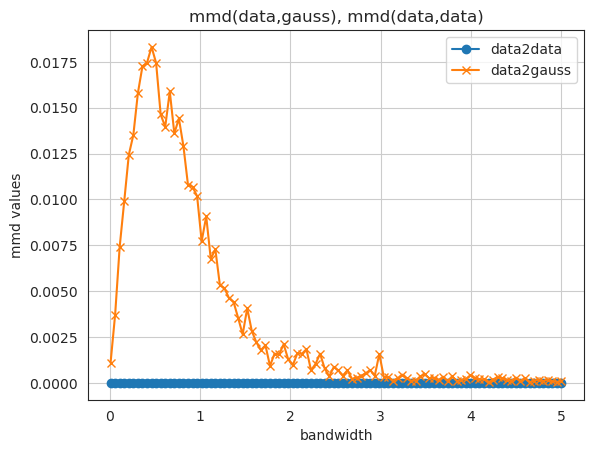

In [15]:
plt.plot(sigma.numpy(), mmd_data2data.numpy(), marker='o', linestyle='-', label='data2data')
plt.plot(sigma.numpy(), mmd_data2gauss.numpy(), marker='x', linestyle='-', label='data2gauss')
plt.xlabel('bandwidth')
plt.ylabel('mmd values')
plt.title('mmd(data,gauss), mmd(data,data)')
plt.grid(True)
plt.legend()
plt.show()

## sigma is the local vairance / std of the narrowest part of the data, for this dino sigma should be pretty small

Control the pass_count, with the same pass_count value, compare the MMDs

But this rely on MMD metric again, and the sigma/bandwith of MMD is a dataset related thing. 

## DDIM Schedule #step=700 -- Parallel Sampling

#### CDL real_dino

(2000, 2)
stats = {'pass_count': 21, 'flops_count': 4565, 'time': 2696.3828125, 'MMD thredshold reached?': True, 'If MMD threshold reached, at No.iter': 10}


(-3.5, 3.5, -3.5, 3.5)

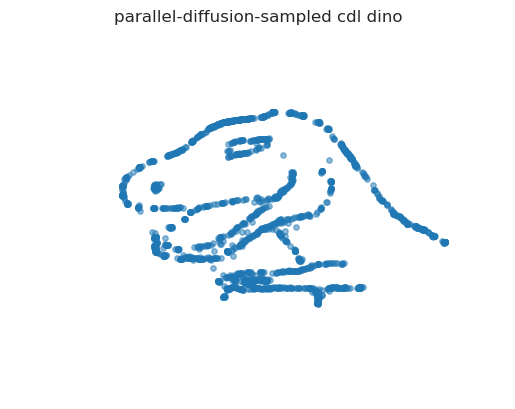

In [16]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddim_scheduler/real_dino/parallel_sampling_cdl_real_dino.pt')
cdl_dino = parallel_sampled_dino.cpu().numpy()
print(cdl_dino.shape)

with open('../test_scripts/results_ddim_scheduler/real_dino/stats_cdl_real_dino.json', 'r') as file: 
    cdl_stats = json.load(file)

print(f'stats = {cdl_stats}')

plt.subplot(1,1,1)
plt.scatter(cdl_dino[:,0], cdl_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled cdl dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

In [17]:
x = torch.load('../test_scripts/results_ddim_scheduler/real_dino/parallel_sampling_cdl_real_dino.pt').cpu()

print(f'threshold=8e-3')
print(f'stats = {cdl_stats}')

mmd_mean = mmd(x0, x, bw=BW)
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

threshold=8e-3
stats = {'pass_count': 21, 'flops_count': 4565, 'time': 2696.3828125, 'MMD thredshold reached?': True, 'If MMD threshold reached, at No.iter': 10}


Parallel sampling MMD = 0.007464165333658457


#### DDPM real_dino

(2000, 2)
stats = {'pass_count': 22, 'flops_count': 6459, 'time': 2866.471435546875, 'MMD thredshold reached?': False}


(-3.5, 3.5, -3.5, 3.5)

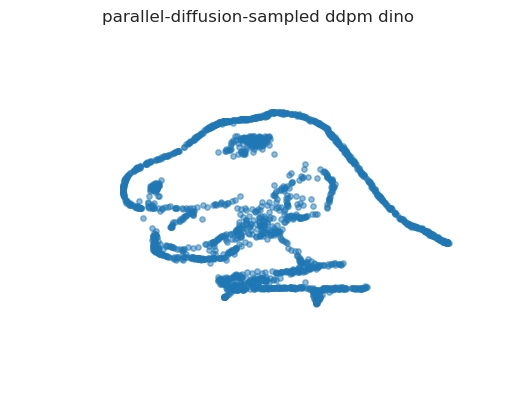

In [18]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddim_scheduler/real_dino/parallel_sampling_ddpm_real_dino.pt')
ddpm_dino = parallel_sampled_dino.cpu().numpy()
print(ddpm_dino.shape)

with open('../test_scripts/results_ddim_scheduler/real_dino/stats_ddpm_real_dino.json', 'r') as file: 
    ddpm_stats = json.load(file)

print(f'stats = {ddpm_stats}')

plt.subplot(1,1,1)
plt.scatter(ddpm_dino[:,0], ddpm_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled ddpm dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

In [19]:
x = torch.load('../test_scripts/results_ddim_scheduler/real_dino/parallel_sampling_ddpm_real_dino.pt').cpu()

print(f'threshold=8e-3')
print(f'stats = {ddpm_stats}')

mmd_mean = mmd(x0, x, bw=BW)
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

threshold=8e-3
stats = {'pass_count': 22, 'flops_count': 6459, 'time': 2866.471435546875, 'MMD thredshold reached?': False}


Parallel sampling MMD = 0.009009385481476784


## DDPM Schedule -- Parallel Sampling

#### CDL real_dino

(2000, 2)
stats = {'pass_count': 36, 'flops_count': 13983, 'time': 1368.282470703125, 'MMD thredshold reached?': True, 'If MMD threshold reached, at No.iter': 27}


(-3.5, 3.5, -3.5, 3.5)

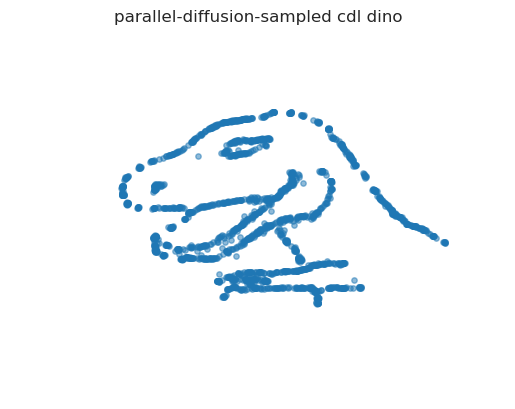

In [20]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_cdl_real_dino.pt')
cdl_dino = parallel_sampled_dino.cpu().numpy()
print(cdl_dino.shape)

with open('../test_scripts/results_ddpm_scheduler/stats_cdl_real_dino.json', 'r') as file: 
    cdl_stats = json.load(file)

print(f'stats = {cdl_stats}')

plt.subplot(1,1,1)
plt.scatter(cdl_dino[:,0], cdl_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled cdl dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

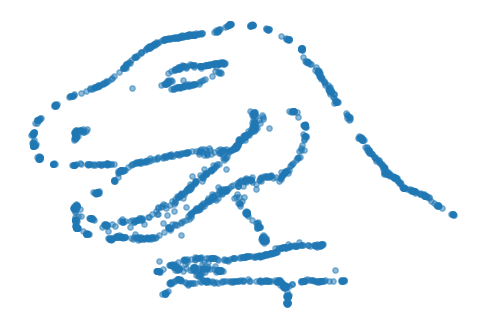

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(cdl_dino[:,0], cdl_dino[:,1], alpha=0.5, s=15)
plt.axis("off")
plt.show()
fig.savefig(f'./dino_cdl.pdf')

In [22]:
x = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_cdl_real_dino.pt').cpu()

print(f'stats = {cdl_stats}')

mmd_mean = mmd(x0, x, bw=BW)
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

stats = {'pass_count': 36, 'flops_count': 13983, 'time': 1368.282470703125, 'MMD thredshold reached?': True, 'If MMD threshold reached, at No.iter': 27}
Parallel sampling MMD = 0.0012278249487280846


Load the mmd list

In [23]:
cdl_mmds = torch.load('../test_scripts/results_ddpm_scheduler/mmd_cdl_real_dino.pt').cpu()
print(cdl_mmds)

tensor([0.0522, 0.0556, 0.0563, 0.0562, 0.0565, 0.0565, 0.0566, 0.0568, 0.0569,
        0.0567, 0.0548, 0.0491, 0.0346, 0.0251, 0.0199, 0.0179, 0.0149, 0.0138,
        0.0102, 0.0088, 0.0077, 0.0055, 0.0051, 0.0036, 0.0031, 0.0022, 0.0016,
        0.0014, 0.0012, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013])


#### CDL flow-dino

(2000, 2)
stats = {'pass_count': 30, 'flops_count': 13622, 'time': 1587.93212890625}


(-3.5, 3.5, -3.5, 3.5)

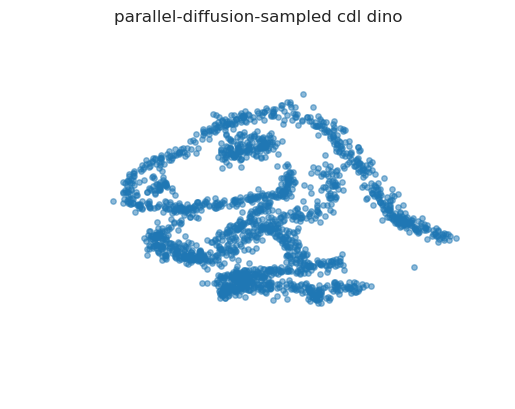

In [24]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_cdl_dino.pt')
cdl_dino = parallel_sampled_dino.cpu().numpy()
print(cdl_dino.shape)

with open('../test_scripts/results_ddpm_scheduler/stats_cdl_dino.json', 'r') as file: 
    cdl_stats = json.load(file)

print(f'stats = {cdl_stats}')

plt.subplot(1,1,1)
plt.scatter(cdl_dino[:,0], cdl_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled cdl dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

In [25]:
true_samples = train_tensor
x = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_cdl_dino.pt').cpu()

print(f'stats = {cdl_stats}')

mmd_mean = mmd(true_samples, x, bw=BW)
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

stats = {'pass_count': 30, 'flops_count': 13622, 'time': 1587.93212890625}
Parallel sampling MMD = 0.0008341891807503998


#### ITD 

(2000, 2)
stats = {'pass_count': 31, 'flops_count': 14282, 'time': 1696.7720947265625}


(-3.5, 3.5, -3.5, 3.5)

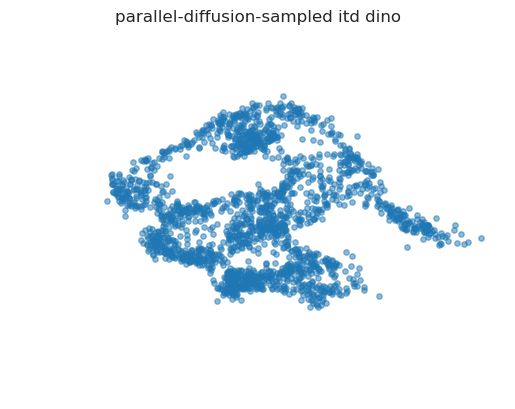

In [26]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_itd_dino.pt')
itd_dino = parallel_sampled_dino.cpu().numpy()
print(itd_dino.shape)

with open('../test_scripts/results_ddpm_scheduler/stats_itd_dino.json', 'r') as file: 
    itd_stats = json.load(file)

print(f'stats = {itd_stats}')

plt.subplot(1,1,1)
plt.scatter(itd_dino[:,0], itd_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled itd dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

In [27]:
true_samples = train_tensor
x = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_itd_dino.pt').cpu()
print(f'stats = {itd_stats}')

mmd_mean = mmd(true_samples, x, bw=torch.tensor(0.001))
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

stats = {'pass_count': 31, 'flops_count': 14282, 'time': 1696.7720947265625}
Parallel sampling MMD = 0.002991796936839819


#### DDPM real_dino

(2000, 2)
stats = {'pass_count': 37, 'flops_count': 14397, 'time': 1870.8824462890625, 'MMD thredshold reached?': False}


(-3.5, 3.5, -3.5, 3.5)

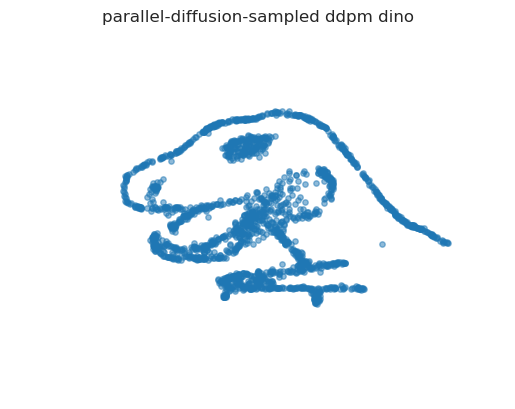

In [28]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_ddpm_real_dino.pt')
ddpm_dino = parallel_sampled_dino.cpu().numpy()
print(ddpm_dino.shape)

with open('../test_scripts/results_ddpm_scheduler/stats_ddpm_real_dino.json', 'r') as file: 
    ddpm_stats = json.load(file)

print(f'stats = {ddpm_stats}')

plt.subplot(1,1,1)
plt.scatter(ddpm_dino[:,0], ddpm_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled ddpm dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

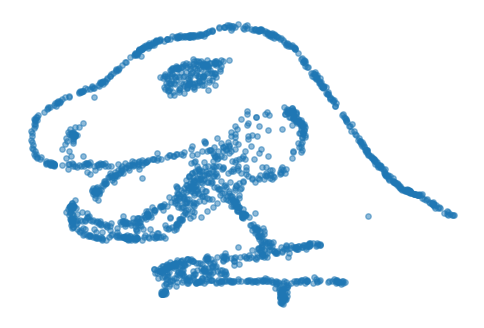

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(ddpm_dino[:,0], ddpm_dino[:,1], alpha=0.5, s=15)
plt.axis("off")
plt.show()
fig.savefig(f'./dino_ddpm.pdf')

In [30]:
x = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_ddpm_real_dino.pt').cpu()
print(f'stats = {ddpm_stats}')

mmd_mean = mmd(x0, x, bw=BW)
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

stats = {'pass_count': 37, 'flops_count': 14397, 'time': 1870.8824462890625, 'MMD thredshold reached?': False}
Parallel sampling MMD = 0.0031076152808964252


In [31]:
ddpm_mmds = torch.load('../test_scripts/results_ddpm_scheduler/mmd_ddpm_real_dino.pt').cpu()
print(ddpm_mmds)

tensor([0.0525, 0.0556, 0.0556, 0.0555, 0.0559, 0.0566, 0.0566, 0.0565, 0.0563,
        0.0561, 0.0516, 0.0387, 0.0264, 0.0253, 0.0227, 0.0200, 0.0164, 0.0137,
        0.0115, 0.0100, 0.0087, 0.0077, 0.0067, 0.0058, 0.0050, 0.0043, 0.0037,
        0.0035, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034,
        0.0034])


#### DDPM flow-dino

(2000, 2)
stats = {'pass_count': 31, 'flops_count': 13781, 'time': 1604.1287841796875}


(-3.5, 3.5, -3.5, 3.5)

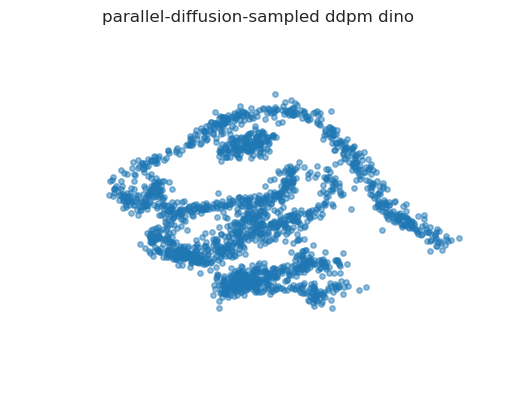

In [32]:
parallel_sampled_dino = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_ddpm_dino.pt')
ddpm_dino = parallel_sampled_dino.cpu().numpy()
print(ddpm_dino.shape)

with open('../test_scripts/results_ddpm_scheduler/stats_ddpm_dino.json', 'r') as file: 
    ddpm_stats = json.load(file)

print(f'stats = {ddpm_stats}')

plt.subplot(1,1,1)
plt.scatter(ddpm_dino[:,0], ddpm_dino[:,1], alpha=0.5, s=15)
plt.title("parallel-diffusion-sampled ddpm dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

In [33]:
true_samples = train_tensor
x = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_ddpm_dino.pt').cpu()
print(f'stats = {ddpm_stats}')

mmd_mean = mmd(true_samples, x, bw=BW)
# mmd_mean = mmd_loss(true_samples, x, sigma=0.3)
print(f'Parallel sampling MMD = {mmd_mean}')

stats = {'pass_count': 31, 'flops_count': 13781, 'time': 1604.1287841796875}
Parallel sampling MMD = 0.0007430319674313068


### Plot MMD vs #iter curve

In [34]:
print(f'ddpm mmd = {len(ddpm_mmds)}')
print(f'cdl mmd = {len(cdl_mmds)}')
len_ = max(len(cdl_mmds), len(ddpm_mmds))

print(f'max len = {len_}')
print(torch.arange(len_))

ddpm mmd = 37
cdl mmd = 36
max len = 37
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36])


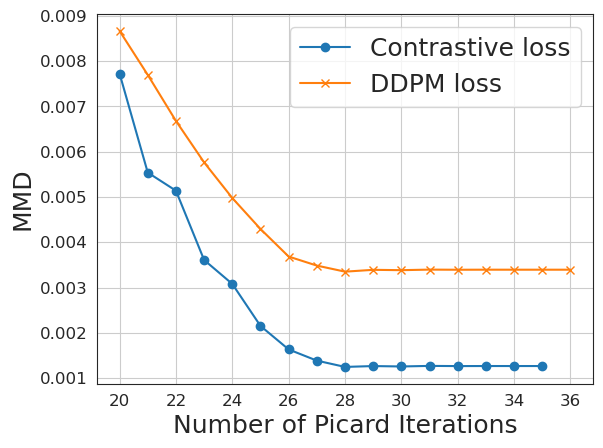

In [40]:
fig, ax = plt.subplots(1, 1)

ax.plot(torch.arange(len(cdl_mmds))[20:].numpy(), cdl_mmds[20:].numpy(), marker='o', linestyle='-', label='Contrastive loss')
ax.plot(torch.arange(len(ddpm_mmds))[20:].numpy(), ddpm_mmds[20:].numpy(), marker='x', linestyle='-', label='DDPM loss')
ax.set_xlabel('Number of Picard Iterations', fontsize=18)  # Set xlabel using set_xlabel
ax.set_ylabel('MMD', fontsize=18)  # Set ylabel using set_ylabel
ax.tick_params(axis='x', which='major', labelsize=12)  
ax.tick_params(axis='y', which='major', labelsize=12)  
ax.grid(True)
ax.legend(fontsize=18)
plt.show()
fig.savefig('./mmd_dino.pdf', bbox_inches='tight')  # Use tight bounding box

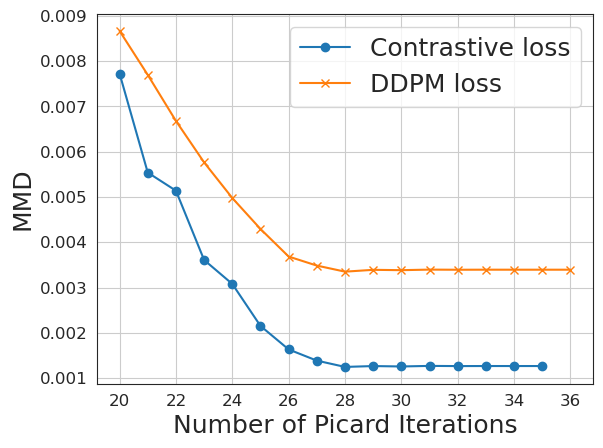

In [ ]:
plt.plot(torch.arange(len(cdl_mmds))[20:].numpy(), cdl_mmds[20:].numpy(), marker='o', linestyle='-', label='Contrastive loss')
plt.plot(torch.arange(len(ddpm_mmds))[20:].numpy(), ddpm_mmds[20:].numpy(), marker='x', linestyle='-', label='DDPM loss')
plt.xlabel('Number of Picard Iterations', fontsize=18)
plt.ylabel('MMD', fontsize=18)
# plt.title('MMD values', fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=12)  
plt.tick_params(axis='y', which='major', labelsize=12)  
plt.grid(True)
plt.legend(fontsize=18)
plt.savefig('./mmd_dino.pdf')
plt.show()

## Sequantial Sampling 

### Load diffusion model dependencies

In [36]:
denoiser_cdl = MLP(2, 64, 3, activation=nn.ReLU, dropout=0.)
ckpt_path_cdl = '../lightning_logs/lightning_logs(forgot to call dataset_info())/0418_dino_epoch2000/version_0_cdl_1perbatch/checkpoints/epoch=1999-step=782000.ckpt'
ckpt_cdl = torch.load(ckpt_path_cdl)
dm_cdl = CDL_DiffusionModel(denoiser_cdl, **ckpt_cdl['hyper_parameters'])
dm_cdl.load_state_dict(ckpt_cdl['state_dict'])
dm_cdl.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../lightning_logs/lightning_logs(forgot to call dataset_info())/0418_dino_epoch2000/version_0_cdl_1perbatch/checkpoints/epoch=1999-step=782000.ckpt'

In [ ]:
denoiser_itd = MLP(2, 64, 3, activation=nn.ReLU, dropout=0.)
ckpt_path_itd = '../lightning_logs/lightning_logs(forgot to call dataset_info())/0418_dino_epoch2000/version_1_itd/checkpoints/epoch=1999-step=782000.ckpt'
ckpt_itd = torch.load(ckpt_path_itd)
dm_itd = ITD_DiffusionModel(denoiser_itd, **ckpt_itd['hyper_parameters'])
dm_itd.load_state_dict(ckpt_itd['state_dict'])
dm_itd.eval()

ITD_DiffusionModel(
  (model): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

In [ ]:
denoiser_ddpm = MLP(2, 64, 3, activation=nn.ReLU, dropout=0.)
ckpt_path_ddpm = '../lightning_logs/lightning_logs(forgot to call dataset_info())/0418_dino_epoch2000/version_2_ddpm/checkpoints/epoch=1999-step=782000.ckpt'
ckpt_ddpm = torch.load(ckpt_path_ddpm)
dm_ddpm = DDPM_DiffusionModel(denoiser_ddpm, **ckpt_ddpm['hyper_parameters'])
dm_ddpm.load_state_dict(ckpt_ddpm['state_dict'])
dm_ddpm.eval()

DDPM_DiffusionModel(
  (model): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

### MMD metric
我咋感觉这个MMD fn写了跟没写一样呢。。。。写废了。。。

In [ ]:
NUM_TEST_SAMPLES = 1000

In [ ]:
# plot MMDs
def plot_mmds(ts_list, mmds_list, labels_list):
    fig1, ax1 = plt.subplots(1, 1)
    for i in range(len(ts_list)):
        ax1.plot(ts_list[i], mmds_list[i], label=labels_list[i])
        ax1.set_xlabel('# gradient evaluations')
        ax1.set_ylabel('MMD')
    ax1.legend()

#### 1. Karras sampler, sequential sampling algorithm

In [ ]:
def karras_sampler(dm, true_samples, logsnr_min=-9., logsnr_max=12., num_steps=10):
    """Karras sampling with MMD test"""
    dm.eval()
    
    sigma_min, sigma_max = logsnr2sigma(logsnr_max), logsnr2sigma(logsnr_min)
    schedule = get_sigmas_karras(num_steps, sigma_min, sigma_max, device=dm.device)
    # print(f'    sampling schedule.shape = {schedule.shape}')
    step_function = get_step(order=2, s_churn=0.1)

    # MMD related
    x_plot_offset = 0.  # avoid overlapping error bars
    mmds = []
    ts = []
    num_samples = true_samples.shape[0]

    x = torch.randn([num_samples, *dm.shape], device=dm.device) * schedule[0]
    for i in trange(len(schedule) - 1, desc='Generating images via karras'):
        x = step_function(dm, x, schedule[i], schedule[i+1])

        if i%1 == 0:
            bw = median_heuristic(true_samples)
            kyy = kernel(true_samples, true_samples, bw)
            kxx = kernel(x, x, bw)
            kxy = kernel(x, true_samples, bw)
            mmd_mean = mmd_ci_kernel(kxx, kxy, kyy)
            mmds.append(mmd_mean)
            ts.append(i + x_plot_offset)

    return x, mmds, ts

In [ ]:
# # Karras steps
# NUM_KARRAS_SAMPLE_STEPS = 15

# # get true samples for MMD test
# train_ds, val_ds, x_shape = sample_2d_synthetic(dataset="dino", num_samples=NUM_TEST_SAMPLES)
# true_sample_tensor = train_ds.tensors[0]

# cdl_samples, cdl_mmds, cdl_ts = karras_sampler(dm_cdl, true_sample_tensor, num_steps=NUM_KARRAS_SAMPLE_STEPS)
# itd_samples, itd_mmds, itd_ts = karras_sampler(dm_itd, true_sample_tensor, num_steps=NUM_KARRAS_SAMPLE_STEPS)
# ddpm_samples, ddpm_mmds, ddpm_ts = karras_sampler(dm_ddpm, true_sample_tensor, num_steps=NUM_KARRAS_SAMPLE_STEPS)

In [ ]:
# ts_list = [cdl_ts, itd_ts, ddpm_ts]
# mmds_list = [cdl_mmds, itd_mmds, ddpm_mmds]
# labels_list = ["CDL", "ITD", "DDPM"]
# plot_mmds(ts_list, mmds_list, labels_list)

plot CDL generated dino

In [ ]:
# print(f'CDL MMD = {cdl_mmds[-1]}')

# plt.subplot(1,1,1)
# plt.scatter(cdl_samples[:,0], cdl_samples[:,1], alpha=0.5, s=15)
# plt.title("cdl dino")
# plt.xlim(-3.5, 3.5)
# plt.ylim(-3.5, 3.5)
# plt.axis("off")

In [ ]:
# print(f'ITD MMD = {itd_mmds[-1]}')

# plt.subplot(1,1,1)
# plt.scatter(itd_samples[:,0], itd_samples[:,1], alpha=0.5, s=15)
# plt.title("itd dino")
# plt.xlim(-3.5, 3.5)
# plt.ylim(-3.5, 3.5)
# plt.axis("off")

In [ ]:
# print(f'DDPM MMD = {ddpm_mmds[-1]}')

# plt.subplot(1,1,1)
# plt.scatter(ddpm_samples[:,0], ddpm_samples[:,1], alpha=0.5, s=15)
# plt.title("ddpm dino")
# plt.xlim(-3.5, 3.5)
# plt.ylim(-3.5, 3.5)
# plt.axis("off")

#### DDPM samplers (BUG here!)

In [ ]:
@torch.no_grad()
def ddpm_sampler(dm, true_samples, 
                 dm_loss='cdl', 
                 start_schedule=0.0001, end_schedule=0.02, num_steps=1000):
    """Karras sampling with MMD test"""
    dm.eval()

    print(f'Sampling from {dm_loss} trained diffusion...')
    
    # MMD related
    x_plot_offset = 0.  # avoid overlapping error bars
    mmds = []
    ts = []
    num_samples = true_samples.shape[0]

    # Calcuate betas of DDPM schedule
    betas = torch.linspace(start_schedule, end_schedule, num_steps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    x = torch.randn([num_samples, *dm.shape], device=dm.device)
    for i in reversed(range(num_steps)):
        # print(f'timestep = {i}')
        timestep = torch.full((1,), i, dtype=torch.long, device=dm.device)

        betas_t = get_by_idx(betas, timestep)
        sqrt_one_minusalphas_cumprod = get_by_idx(torch.sqrt(1. - alphas_cumprod), timestep) # mixing ratio (1-alpha_bar_t)
        sqrt_recip_alphas_t = get_by_idx(torch.sqrt(1. / alphas), timestep)

        # logsnr = t2logsnr(timestep, alphas_cumprod).repeat(num_samples)
        # mean_t = sqrt_recip_alphas_t * (x - betas_t * dm(x, logsnr) / sqrt_one_minusalphas_cumprod)
        # posterior_var_t = betas_t

        if dm_loss.lower() == 'cdl' or dm_loss.lower() == 'itd':
            # translate t to logsnr
            logsnr = t2logsnr(timestep, alphas_cumprod).repeat(num_samples)
            # print(f'    logsnr.shape = {logsnr.shape}')
            # Estimated noisy data x_t
            mean_t = sqrt_recip_alphas_t * (x - betas_t * dm(x, logsnr) / sqrt_one_minusalphas_cumprod)
            posterior_var_t = betas_t
        elif dm_loss.lower() == 'ddpm':
            t_ = timestep.repeat(num_samples) # FIXME: do I really need this? yes
            mean_t = sqrt_recip_alphas_t * (x - betas_t * dm(x, t_) / sqrt_one_minusalphas_cumprod)
            posterior_var_t = betas_t

        if timestep == 0:
            x = mean_t # if t=0, do not add noise
        else:
            eps = torch.randn_like(x)
            var_t = torch.sqrt(posterior_var_t) * eps
            x = mean_t + var_t

        if i%1 == 0:
            bw = median_heuristic(true_samples)
            kyy = kernel(true_samples, true_samples, bw)
            kxx = kernel(x, x, bw)
            kxy = kernel(x, true_samples, bw)
            mmd_mean = mmd_ci_kernel(kxx, kxy, kyy)
            mmds.append(mmd_mean)
            ts.append(i + x_plot_offset)

    return x, mmds, ts

In [ ]:
# Karras steps
NUM_KARRAS_SAMPLE_STEPS = 1000

# get true samples for MMD test
train_ds, val_ds, x_shape = sample_2d_synthetic(dataset="dino", num_samples=NUM_TEST_SAMPLES)
true_sample_tensor = train_ds.tensors[0]

cdl_samples, cdl_mmds, cdl_ts = ddpm_sampler(dm_cdl, true_sample_tensor, dm_loss='cdl', num_steps=NUM_KARRAS_SAMPLE_STEPS)
itd_samples, itd_mmds, itd_ts = ddpm_sampler(dm_itd, true_sample_tensor, dm_loss='itd', num_steps=NUM_KARRAS_SAMPLE_STEPS)
ddpm_samples, ddpm_mmds, ddpm_ts = ddpm_sampler(dm_ddpm, true_sample_tensor, dm_loss='ddpm', num_steps=NUM_KARRAS_SAMPLE_STEPS)

Sampling from cdl trained diffusion...
Sampling from itd trained diffusion...
Sampling from ddpm trained diffusion...


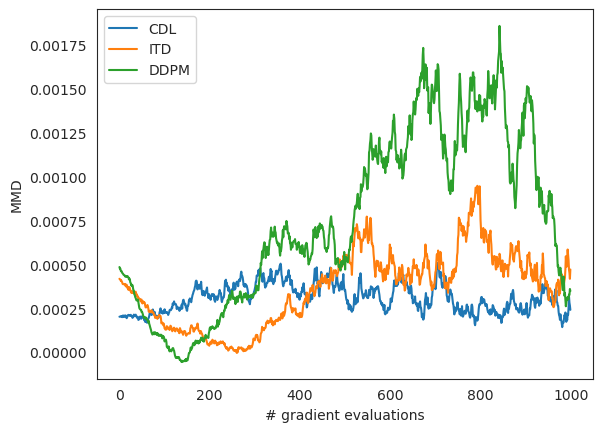

In [ ]:
ts_list = [cdl_ts, itd_ts, ddpm_ts]
mmds_list = [cdl_mmds, itd_mmds, ddpm_mmds]
labels_list = ["CDL", "ITD", "DDPM"]
plot_mmds(ts_list, mmds_list, labels_list)

CDL MMD = 0.00020141751156188548


(-3.5, 3.5, -3.5, 3.5)

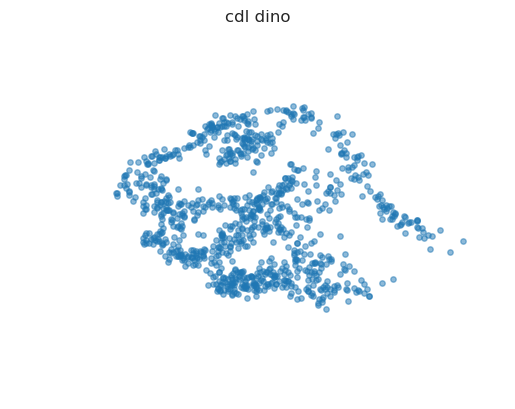

In [ ]:
print(f'CDL MMD = {cdl_mmds[-1]}')

plt.subplot(1,1,1)
plt.scatter(cdl_samples[:,0], cdl_samples[:,1], alpha=0.5, s=15)
plt.title("cdl dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

ITD MMD = 0.0004171710752416402


(-3.5, 3.5, -3.5, 3.5)

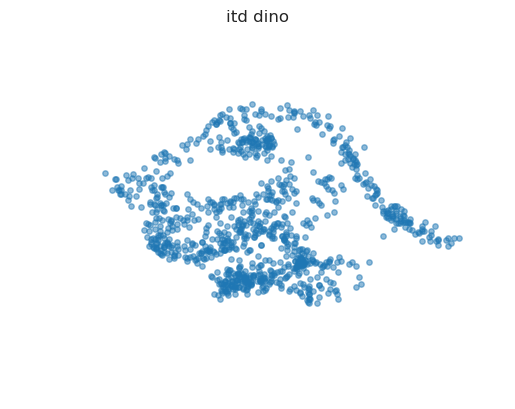

In [ ]:
print(f'ITD MMD = {itd_mmds[-1]}')

plt.subplot(1,1,1)
plt.scatter(itd_samples[:,0], itd_samples[:,1], alpha=0.5, s=15)
plt.title("itd dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")

DDPM MMD = 0.0004839525499846786
ddpm-trained dino = tensor([[-0.1515,  0.4260],
        [-0.2297, -0.1179],
        [ 1.5481,  0.6105],
        ...,
        [-0.1361,  1.8264],
        [-0.2042, -0.4690],
        [ 1.6211,  0.4765]])


(-3.5, 3.5, -3.5, 3.5)

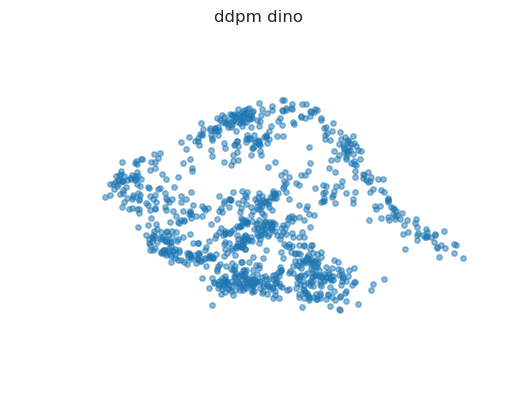

In [ ]:
print(f'DDPM MMD = {ddpm_mmds[-1]}')

print(f'ddpm-trained dino = {ddpm_samples}')

plt.subplot(1,1,1)
plt.scatter(ddpm_samples[:,0], ddpm_samples[:,1], alpha=0.5, s=15)
plt.title("ddpm dino")
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.axis("off")